In [1]:
import torch
import torchvision
from networks import ResnetGenerator
from IPython.display import Video
from tqdm.notebook import trange
from skimage.exposure import match_histograms
import matplotlib.pyplot as plt

In [2]:
def to_tensor(x, device):
    x = x.type(torch.float) / 255.0
    x = (x - 0.5) / 0.5
    x = x.permute(0, 3, 1, 2)
    x = x.to(device)
    return x

def to_video(x):
    x = x.permute(0, 2, 3, 1)
    x = (x * 0.5) + 0.5
    x = x * 255.0
    x = x.type(torch.uint8)
    x = x.cpu()
    return x

In [3]:
def match_histogram(video):
    output_video = torch.zeros_like(video)
    for i in trange(video.size(0)):
        # Each video is 10 sec = 240 frames
        # Use frame 120 of each video as a reference frame
        reference_index = 120 + (i // 240) * 240
        reference_frame = video[reference_index].numpy()
        old_frame = video[i].numpy()
        new_frame = match_histograms(old_frame, reference_frame, multichannel=True)
        output_video[i] = torch.from_numpy(new_frame)
    return output_video

In [4]:
def match_histogram_one_frame(video, frame_no):
    i = frame_no
    # Each video is 10 sec = 240 frames
    # Use frame 120 of each video as a reference frame
    reference_index = 120 + (i // 240) * 240
    reference_frame = video[reference_index].numpy()
    old_frame = video[i].numpy()
    new_frame = match_histograms(old_frame, reference_frame, multichannel=True)
    
    return reference_frame, old_frame, new_frame

In [5]:
def forward(model, device, input_video):
    input_tensor = to_tensor(input_video, device)
    output_tensor = torch.zeros_like(input_tensor)
    with torch.no_grad():
        for i in trange(input_tensor.size(0)):
            input_frame = input_tensor[i].unsqueeze(0)
            output_frame, _ ,_ = model(input_frame)
            output_tensor[i] = output_frame
    output_video = to_video(output_tensor)
    return output_video

In [6]:
def process_video(model, device, input_video_path, output_video_path):
    input_video, _, _ = torchvision.io.read_video(input_video_path, pts_unit="sec")
    input_video_match_histogram = match_histogram(input_video)
        
    output_video = forward(model, device, input_video)
    output_video_match_historgram = forward(model, device, input_video_match_histogram)
    output_video_match_historgram = match_histogram(output_video_match_historgram)
    
    merge = torch.cat((input_video, output_video, output_video_match_historgram), dim=2)
    torchvision.io.write_video(output_video_path, merge, fps=24.0)

In [7]:
def get_model(device):
    model = ResnetGenerator()
    model.load_state_dict(torch.load("state_dict/genA2B_best.pt", map_location="cpu"))
    for p in model.parameters():
        p.required_grad = False
    model.eval()
    model = model.to(device)
    return model

In [8]:
def plot_his(reference_frame, old_frame, new_frame):
    
    fig, ax = plt.subplots(2, 3, figsize=(20,10))
    
    ax[0,0].hist(reference_frame.ravel(), bins = 128, color = 'orange', )
    ax[0,0].hist(reference_frame[:, :, 0].ravel(), bins = 128, color = 'red', alpha = 0.5)
    ax[0,0].hist(reference_frame[:, :, 1].ravel(), bins = 128, color = 'Green', alpha = 0.5)
    ax[0,0].hist(reference_frame[:, :, 2].ravel(), bins = 128, color = 'Blue', alpha = 0.5)
    ax[0,0].set_xlabel("Reference frame's histogram")
    ax[0,0].set_ylabel('Count')
    ax[0,0].legend(['RGB', 'R', 'G', 'B'])
    
    ax[0,1].hist(old_frame.ravel(), bins = 128, color = 'orange', )
    ax[0,1].hist(old_frame[:, :, 0].ravel(), bins = 128, color = 'red', alpha = 0.5)
    ax[0,1].hist(old_frame[:, :, 1].ravel(), bins = 128, color = 'Green', alpha = 0.5)
    ax[0,1].hist(old_frame[:, :, 2].ravel(), bins = 128, color = 'Blue', alpha = 0.5)
    ax[0,1].set_xlabel("Original frame's histogram")
    ax[0,1].set_ylabel('Count')
    ax[0,1].legend(['RGB', 'R', 'G', 'B'])
    
    ax[0,2].hist(new_frame.ravel(), bins = 128, color = 'orange', )
    ax[0,2].hist(new_frame[:, :, 0].ravel(), bins = 128, color = 'red', alpha = 0.5)
    ax[0,2].hist(new_frame[:, :, 1].ravel(), bins = 128, color = 'Green', alpha = 0.5)
    ax[0,2].hist(new_frame[:, :, 2].ravel(), bins = 128, color = 'Blue', alpha = 0.5)
    ax[0,2].set_xlabel("New frame's histogram")
    ax[0,2].set_ylabel('Count')
    ax[0,2].legend(['RGB', 'R', 'G', 'B'])
    
    ax[1,0].imshow(reference_frame)
    ax[1,0].set_xlabel("Reference frame")

    ax[1,1].imshow(old_frame)
    ax[1,1].set_xlabel("Original frame")

    ax[1,2].imshow(new_frame)
    ax[1,2].set_xlabel("New frame")
    
    plt.savefig("media/histogram.jpg")
    plt.show()

# Show matching histogram figure

In [9]:
device = torch.device("cuda:3")
input_video_path = "media/input_video.mp4"
output_video_path = "media/output_video.mp4"

In [10]:
model = get_model(device)

In [11]:
input_video_path = "media/input_video.mp4"
input_video, _, _ = torchvision.io.read_video(input_video_path, pts_unit="sec")
output_video = forward(model, device, input_video)

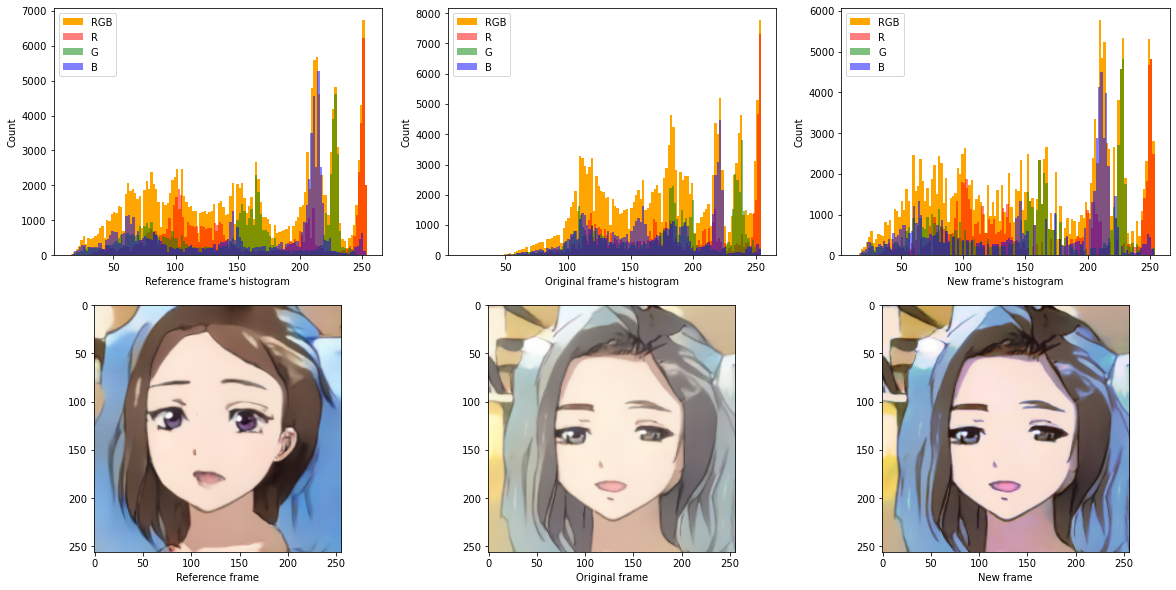

In [12]:
reference_frame, old_frame, new_frame = match_histogram_one_frame(output_video, frame_no=3*240)
plot_his(reference_frame, old_frame, new_frame)

# Process a whole video

In [13]:
%%time
process_video(model, device, input_video_path, output_video_path)


CPU times: user 19min 21s, sys: 1min 18s, total: 20min 39s
Wall time: 1min 55s


In [14]:
Video(output_video_path)